# Fitting discrete distributions with weights

Here, I outline the strategy for fitting the underlying distribution from discretized data points that have weights.

In [149]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
from statsmodels.stats.weightstats import DescrStatsW
import statsmodels.api as sm
import numpy as np
import itertools
import time

### Simulate some data

In [15]:
# Parameters
num_cells = 1000
p = 0.1
mu = 10
sigma = 3

In [16]:
continuous = np.random.normal(mu, sigma, size=num_cells)

In [17]:
ground_truth_counts = np.clip(np.round(continuous), a_min=0, a_max=100).astype(np.int64)

In [19]:
pd.Series(ground_truth_counts).value_counts()

10    133
9     123
11    119
12    117
8     110
13     78
7      76
14     55
6      48
15     37
5      31
4      26
16     19
17     11
3       7
19      3
20      2
0       2
18      1
2       1
1       1
dtype: int64

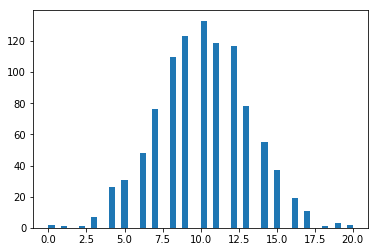

In [18]:
plt.hist(ground_truth_counts, bins=50);

In [9]:
observed = np.random.binomial(n=ground_truth_counts, p=p)

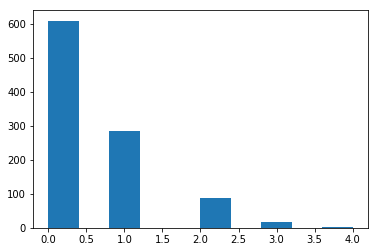

In [11]:
plt.hist(observed);

## Sanity check regressions

In [143]:
control_mu = 10
control_sigma = 3
case_mu = 3
case_sigma = 15
N = 5000

control_data = np.random.normal(loc=control_mu, scale=control_sigma, size=N)
case_data = np.random.normal(loc=case_mu, scale=case_sigma, size=N)
y = np.concatenate([control_data, case_data])
x = np.concatenate([np.zeros(N), np.ones(N)])

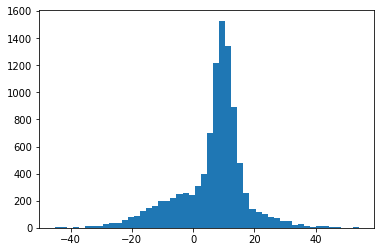

In [144]:
plt.hist(y, bins=50);

In [145]:
x = sm.add_constant(x)

In [146]:
model = sm.WLS(y, x, np.concatenate([np.ones(N)*1/control_sigma**2, np.ones(N)*1/case_sigma**2])).fit()
model_naive = sm.WLS(y, x).fit()

In [147]:
model_naive.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.097
Model:                            WLS   Adj. R-squared:                  0.097
Method:                 Least Squares   F-statistic:                     1073.
Date:                Mon, 18 Mar 2019   Prob (F-statistic):          1.01e-223
Time:                        19:43:53   Log-Likelihood:                -37671.
No. Observations:               10000   AIC:                         7.535e+04
Df Residuals:                    9998   BIC:                         7.536e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9720      0.148     67.366      0.000       9.682      10.262
x1            -6.8587      0.209    -32.763      0.000      -7.269      -6.448
==============================================================================
Omnibus:                      593.983   Durbin-Watson:                   2.041
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2547.191
Skew:                           0.079   Prob(JB):                         0.00
Kurtosis:                       5.467   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [148]:
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            WLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.094
Model:                            WLS   Adj. R-squared:                  0.093
Method:                 Least Squares   F-statistic:                     1031.
Date:                Mon, 18 Mar 2019   Prob (F-statistic):          1.82e-215
Time:                        19:44:01   Log-Likelihood:                -33093.
No. Observations:               10000   AIC:                         6.619e+04
Df Residuals:                    9998   BIC:                         6.620e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          9.9720      0.042    238.095      0.000       9.890      10.054
x1            -6.8587      0.214    -32.116      0.000      -7.277      -6.440
==============================================================================
Omnibus:                        2.847   Durbin-Watson:                   2.026
Prob(Omnibus):                  0.241   Jarque-Bera (JB):                2.866
Skew:                           0.033   Prob(JB):                        0.239
Kurtosis:                       2.951   Cond. No.                         5.21
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [127]:
point_var = (y - model.predict(x))**2

In [128]:
var_model = sm.OLS(point_var, x).fit()

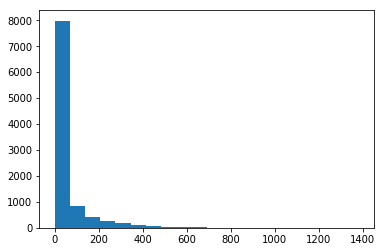

In [129]:
plt.hist(point_var, bins=20);

In [130]:
var_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.170
Model:                            OLS   Adj. R-squared:                  0.170
Method:                 Least Squares   F-statistic:                     2051.
Date:                Mon, 18 Mar 2019   Prob (F-statistic):               0.00
Time:                        19:17:12   Log-Likelihood:                -60114.
No. Observations:               10000   AIC:                         1.202e+05
Df Residuals:                    9998   BIC:                         1.202e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          8.8729      1.396      6.354      0.000       6.136      11.610
x1            89.4443      1.975     45.292      0.000      85.573      93.315
==============================================================================
Omnibus:                     8412.761   Durbin-Watson:                   2.011
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           289601.998
Skew:                           3.908   Prob(JB):                         0.00
Kurtosis:                      28.179   Cond. No.                         2.62
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [94]:
sm.MixedLM(y, x, groups=x[:, 1]).fit().random_effects

/anaconda3/envs/scvi/lib/python3.6/site-packages/statsmodels/regression/mixed_linear_model.py:2066: ConvergenceWarning: The Hessian matrix at the estimated parameter values is not positive definite.
  warnings.warn(msg, ConvergenceWarning)


{0.0: Group Var    2.115344e-09
 dtype: float64, 1.0: Group Var    6.862618e-10
 dtype: float64}

In [95]:
print(sm.MixedLM(y, x[:, 0], groups=x[:, 1]).fit().summary())

          Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: y          
No. Observations: 10000   Method:             REML       
No. Groups:       2       Scale:              52.5835    
Min. group size:  5000    Likelihood:         -34006.4574
Max. group size:  5000    Converged:          Yes        
Mean group size:  5000.0                                 
----------------------------------------------------------
            Coef.   Std.Err.    z    P>|z|  [0.025  0.975]
----------------------------------------------------------
const        6.522     3.428  1.903  0.057  -0.196  13.241
Group Var   23.491     4.603                              



In [101]:
sm.MixedLM(y, x[:, 0], groups=x[:, 1]).fit().cov_re

array([[23.49074351]])

In [97]:
6.522 + 3.419129

9.941129

In [155]:
stats.norm.cdf([1, 3], loc=[0, 1], scale=[1, 2])

array([0.84134475, 0.84134475])

###